# Convolutional Neural Network for Animal Image Classification

## Project Overview

This project implements a Convolutional Neural Network (CNN) 
to classify images of animals into predefined categories.

The objective is to demonstrate:

- Image preprocessing
- CNN architecture design
- Model training and validation
- Performance evaluation
- Overfitting analysis

## Environment Setup (Google Colab)

The project was developed in Google Colab.

This section:
- Mounts Google Drive
- Extracts the image dataset
- Prepares the working directory

These steps are required only when running the notebook in Colab.

In [2]:
from google.colab import drive  # Import Colab module to interact with Google Drive
drive.mount('/content/drive')   # Mount Google Drive to access/save files like models or datasets

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/raw-img.zip" -d /content   # Unzip the dataset into the working directory

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: /content/raw-img/mucca/OIP-DkXxCkafIjEhPUTBttgdXwHaGV.jpeg  
  inflating: /content/raw-img/mucca/OIP-dlEojPypIkt--w3ukDrOFgHaKe.jpeg  
  inflating: /content/raw-img/mucca/OIP-dMeYaM8lBN6VyxkC9yGzJgHaE0.jpeg  
  inflating: /content/raw-img/mucca/OIP-d-mHAzg4B6W4TWyy6wYyEgHaHC.jpeg  
  inflating: /content/raw-img/mucca/OIP-dMqgKdcpE_sPyravYVx6bwHaE8.jpeg  
  inflating: /content/raw-img/mucca/OIP-dmY9BONyQk7y4Zi_bZ8dBgHaLk.jpeg  
  inflating: /content/raw-img/mucca/OIP-DmYzE5ynJ5btrQ-5920cpgHaFi.jpeg  
  inflating: /content/raw-img/mucca/OIP-DNdGx8Himj2C7NCdjGKnIQHaE7.jpeg  
  inflating: /content/raw-img/mucca/OIP-dNJgK5IB3FoNiJREMn16rQHaE8.jpeg  
  inflating: /content/raw-img/mucca/OIP-do0zeZP--MBAEE4s42WhXQHaEo.jpeg  
  inflating: /content/raw-img/mucca/OIP-dpSTRM34jEhx5Ld_57AUPwAAAA.jpeg  
  inflating: /content/raw-img/mucca/OIP-dr3kN4Z8cpibwQqVWXhpRQHaGX.jpeg  
  inflating: /content/raw-img/mucca/OIP-Dr4xrzq

## 1. Dataset Preparation

The dataset consists of labeled animal images stored in class-specific folders.

Images are loaded using Keras utilities and divided into:

- Training set
- Validation set
- Test set

Each image is resized to a fixed resolution before being fed into the network.

In [ ]:
import os                                                                                         # Operating system utilities
import numpy as np                                                                                # Numerical operations
import json                                                                                       # Read/write JSON files (for saving class labels)
import matplotlib.pyplot as plt                                                                   # Plotting training performance
import tensorflow as tf                                                                           # TensorFlow framework
from tensorflow.keras.preprocessing.image import ImageDataGenerator                               # For loading and augmenting image data
from tensorflow.keras.applications import ResNet50                                                # Pre-trained ResNet50 model
from tensorflow.keras.models import Model, load_model                                             # Define and load Keras models
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout    # Layers for custom classification head
from tensorflow.keras.optimizers import Adam                                                      # Optimizer
from tensorflow.keras.callbacks import ModelCheckpoint                                            # Save the best model during training
from sklearn.metrics import classification_report, confusion_matrix                               # Evaluate model performance

# Define training configuration
img_height, img_width = 224, 224                            # Input image dimensions
batch_size = 32                                             # Number of images per training batch
epochs = 10                                                 # Total number of training epochs

# Define dataset and output file paths
data_dir = "/content/raw-img"                               # Path to image dataset (after unzip)
model_path = "/content/drive/MyDrive/animal_model.h5"       # Where to save the trained model
labels_path = "/content/drive/MyDrive/class_labels.json"    # Where to save the list of class labels

### Data Augmentation

To improve generalization and reduce overfitting, 
data augmentation techniques are applied during training.

These transformations may include:

- Rescaling pixel values
- Random rotations
- Horizontal flips
- Zoom transformations

This artificially increases dataset diversity.

In [ ]:
# Create an ImageDataGenerator for training and validation with real-time data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,                       # Normalize pixel values to the range [0, 1]
    validation_split=0.2,                 # Use 20% of data for validation
    rotation_range=15,                    # Randomly rotate images by up to 15 degrees
    width_shift_range=0.1,                # Randomly shift images horizontally
    height_shift_range=0.1,               # Randomly shift images vertically
    shear_range=0.1,                      # Apply random shearing transformations
    zoom_range=0.2,                       # Apply random zoom
    horizontal_flip=True                  # Randomly flip images horizontally
)

# Load training data from folders using directory structure
train_generator = train_datagen.flow_from_directory(
    data_dir,                                           # Root folder containing subfolders for each class
    target_size=(img_height, img_width),                # Resize images to match model input size
    batch_size=batch_size,                              # Number of images per batch
    class_mode='categorical',                           # Multi-class classification
    subset='training'                                   # Load only training portion (80%)
)

# Load validation data (20%) from the same directory structure
val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 7464 images belonging to 5 classes.
Found 1864 images belonging to 5 classes.


In [ ]:
class_labels = list(train_generator.class_indices.keys())   # Get a list of class names from the training generator
with open(labels_path, "w") as f:
    json.dump(class_labels, f)                              # Save class labels as a JSON file to reuse during prediction
print("Class labels saved:", class_labels)                  # Print the list of saved class names

Class labels saved: ['farfalla', 'gatto', 'mucca', 'pecora', 'scoiattolo']


## 2. Transfer Learning with ResNet50

This model uses transfer learning with a pre-trained ResNet50 backbone.

Steps performed:

- Load ResNet50 without the top classification layer
- Freeze early convolutional layers
- Fine-tune the last 40 layers
- Add a custom classification head
- Compile the model with Adam optimizer

In [ ]:
# Load the pre-trained ResNet50 model (without its top classification layer)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze early layers to keep previously learned features
for layer in base_model.layers[:-40]:
    layer.trainable = False

# Allow the last 40 layers to be trainable (fine-tuning)
for layer in base_model.layers[-40:]:
    layer.trainable = True

# ➕ Add custom classification head on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)                                                 # Reduce spatial dimensions
x = BatchNormalization()(x)                                                     # Normalize to stabilize learning
x = Dense(128, activation='relu')(x)                                            # Fully connected layer
x = Dropout(0.3)(x)                                                             # Dropout for regularization
predictions = Dense(train_generator.num_classes, activation='softmax')(x)       # Output layer

# Define the full model and compile it
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(
    optimizer=Adam(learning_rate=0.0001),                       # Adam optimizer with low learning rate
    loss='categorical_crossentropy',                            # Loss function for multi-class classification
    metrics=['accuracy']                                        # Track accuracy during training
)

# Display model architecture
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,858,821 (91.01 MB)

 Trainable params: 16,098,821 (61.41 MB)

 Non-trainable params: 7,760,000 (29.60 MB)

## 3. Model Training

The model is trained on the training dataset 
and validated on a separate validation set.

During training, we monitor:

- Training accuracy
- Validation accuracy
- Training loss
- Validation loss

These metrics help detect overfitting or underfitting.

In [ ]:
# Define a callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
    "/content/models/best_model.h5",            # Path to save the best version of the model
    monitor='val_accuracy',                     # Monitor validation accuracy during training
    save_best_only=True,                        # Save only the best performing model
    verbose=1                                   # Print a message each time a model is saved
)

# Train the model using the training and validation sets
history = model.fit(
    train_generator,                    # Training data
    epochs=epochs,                      # Number of training epochs
    validation_data=val_generator,      # Validation data
    callbacks=[checkpoint]              # Use callback to save the best model
)

# Save the final model to Google Drive (even if it's not the best one)
model.save(model_path)
print(f"Final model saved to {model_path}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.4544 - loss: 1.4584
Epoch 1: val_accuracy improved from -inf to 0.29721, saving model to /content/models/best_model.h5


234/234 ━━━━━━━━━━━━━━━━━━━━ 188s 677ms/step - accuracy: 0.4546 - loss: 1.4578 - val_accuracy: 0.2972 - val_loss: 1.5279
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.5762 - loss: 1.1040
Epoch 2: val_accuracy improved from 0.29721 to 0.39539, saving model to /content/models/best_model.h5


234/234 ━━━━━━━━━━━━━━━━━━━━ 127s 545ms/step - accuracy: 0.5762 - loss: 1.1039 - val_accuracy: 0.3954 - val_loss: 1.5099
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.6183 - loss: 1.0011
Epoch 3: val_accuracy improved from 0.39539 to 0.40504, saving model to /content/models/best_model.h5


234/234 ━━━━━━━━━━━━━━━━━━━━ 129s 550ms/step - accuracy: 0.6183 - loss: 1.0011 - val_accuracy: 0.4050 - val_loss: 2.0771
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.6261 - loss: 0.9752
Epoch 4: val_accuracy did not improve from 0.40504
234/234 ━━━━━━━━━━━━━━━━━━━━ 128s 548ms/step - accuracy: 0.6261 - loss: 0.9752 - val_accuracy: 0.3214 - val_loss: 2.5734
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.6270 - loss: 0.9591
Epoch 5: val_accuracy did not improve from 0.40504
234/234 ━━━━━━━━━━━━━━━━━━━━ 127s 541ms/step - accuracy: 0.6270 - loss: 0.9590 - val_accuracy: 0.3219 - val_loss: 2.2234
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.6457 - loss: 0.9091
Epoch 6: val_accuracy improved from 0.40504 to 0.52253, saving model to /content/models/best_model.h5


234/234 ━━━━━━━━━━━━━━━━━━━━ 146s 623ms/step - accuracy: 0.6457 - loss: 0.9091 - val_accuracy: 0.5225 - val_loss: 2.5297
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.6519 - loss: 0.8958
Epoch 7: val_accuracy did not improve from 0.52253
234/234 ━━━━━━━━━━━━━━━━━━━━ 131s 558ms/step - accuracy: 0.6519 - loss: 0.8958 - val_accuracy: 0.2967 - val_loss: 2.6417
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.6589 - loss: 0.8968
Epoch 8: val_accuracy did not improve from 0.52253
234/234 ━━━━━━━━━━━━━━━━━━━━ 127s 541ms/step - accuracy: 0.6589 - loss: 0.8967 - val_accuracy: 0.3568 - val_loss: 1.7944
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.6666 - loss: 0.8841
Epoch 9: val_accuracy did not improve from 0.52253
234/234 ━━━━━━━━━━━━━━━━━━━━ 129s 550ms/step - accuracy: 0.6667 - loss: 0.8839 - val_accuracy: 0.4898 - val_loss: 1.6912
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.6843 - loss: 0.8230
Epoch 10: 

Final model saved to /content/drive/MyDrive/animal_model.h5


## 4. Training Curve Analysis

The training and validation curves are analyzed to evaluate:

- Convergence behavior
- Stability of learning
- Overfitting or underfitting

A significant gap between training and validation accuracy 
indicates potential overfitting.

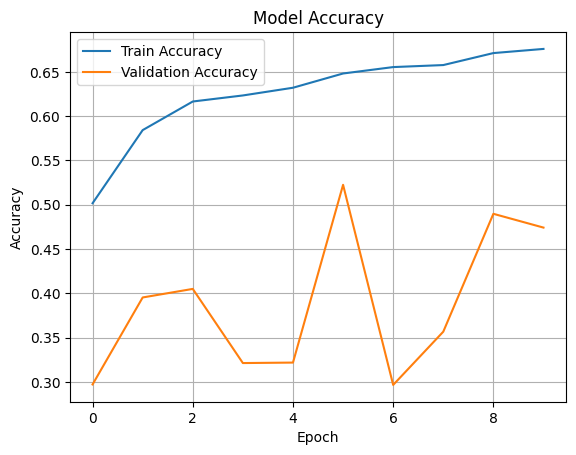

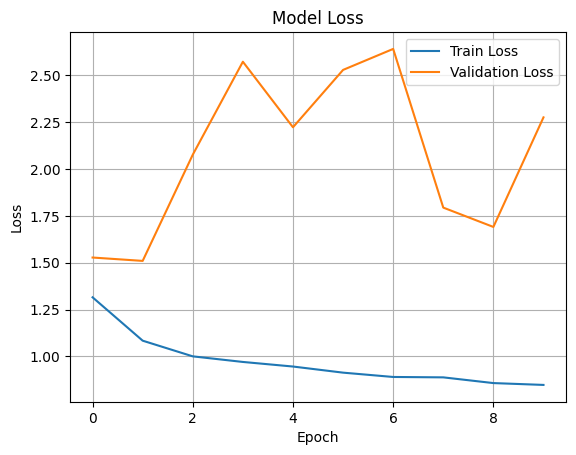

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')               # Accuracy on training data
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')      # Accuracy on validation data
plt.title('Model Accuracy')                                                 # Plot title
plt.xlabel('Epoch')                                                         # X-axis label
plt.ylabel('Accuracy')                                                      # Y-axis label
plt.legend()                                                                # Show legend
plt.grid(True)                                                              # Add grid to the plot
plt.show()                                                                  # Display the plot

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')               # Loss on training data
plt.plot(history.history['val_loss'], label='Validation Loss')      # Loss on validation data
plt.title('Model Loss')                                             # Plot title
plt.xlabel('Epoch')                                                 # X-axis label
plt.ylabel('Loss')                                                  # Y-axis label
plt.legend()                                                        # Show legend
plt.grid(True)                                                      # Add grid to the plot
plt.show()                                                          # Display the plot

### Observations

The training accuracy increases steadily across epochs.

However, validation accuracy fluctuates and remains significantly lower 
than training accuracy.

This suggests:

- The model may be overfitting
- The dataset may be relatively small
- Fine-tuning may require more epochs or additional regularization

Possible improvements:

- Increase dropout rate
- Add data augmentation
- Use EarlyStopping
- Reduce number of trainable layers

## 5. Validation Evaluation

The model is evaluated on the validation dataset 
using a confusion matrix and classification report.

This allows detailed inspection of:

- Per-class precision
- Per-class recall
- F1-score
- Overall accuracy

In [ ]:
val_generator.reset() # Reset the generator to start prediction from the beginning

# Generate predictions for the validation set
preds = model.predict(val_generator, verbose=1)     # Predict probabilities for all classes
y_pred = np.argmax(preds, axis=1)                   # Convert probabilities to predicted class indices
y_true = val_generator.classes                      # True class labels from the validation set

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)       # Compare predicted vs. true labels
print("\nConfusion Matrix:")
print(cm)                                   # Display the confusion matrix

# Generate classification report
report = classification_report(
    y_true, y_pred,
    target_names=class_labels,        # Match indices to class names
    zero_division=0                   # Avoid division by zero in metrics
)
print("\nClassification Report:")
print(report)                         # Show precision, recall, f1-score for each class

59/59 ━━━━━━━━━━━━━━━━━━━━ 31s 449ms/step

Confusion Matrix:
[[ 52 234 133   2   1]
 [ 55 170 107   1   0]
 [ 67 200 106   0   0]
 [ 68 196 100   0   0]
 [ 40 225 106   0   1]]

Classification Report:
              precision    recall  f1-score   support

    farfalla       0.18      0.12      0.15       422
       gatto       0.17      0.51      0.25       333
       mucca       0.19      0.28      0.23       373
      pecora       0.00      0.00      0.00       364
  scoiattolo       0.50      0.00      0.01       372

    accuracy                           0.18      1864
   macro avg       0.21      0.18      0.13      1864
weighted avg       0.21      0.18      0.13      1864



### Evaluation Analysis

The overall validation accuracy is relatively low (~18%).

The confusion matrix and classification report indicate:

- The model struggles to generalize to the validation set.
- Some classes receive near-zero recall.
- Predictions are biased toward certain classes.

This suggests:

- Possible overfitting despite transfer learning.
- Insufficient fine-tuning.
- Class imbalance.
- Need for stronger regularization or longer training.

Potential improvements:

- Increase data augmentation.
- Unfreeze fewer layers during fine-tuning.
- Train for more epochs.
- Use class weights.
- Apply EarlyStopping.

## 6. Model Inference on New Images

The trained model is loaded from disk and used to classify new images.

Steps performed:

- Load saved model
- Load class label mappings
- Upload a new image
- Preprocess the image
- Generate prediction

In [16]:
from tensorflow.keras.models import load_model              # Import function to load a saved Keras model
import json                                                 # Import JSON module to read class label mappings

model_path = "/content/drive/MyDrive/animal_model.h5"       # Path to the trained model file
labels_path = "/content/drive/MyDrive/class_labels.json"    # Path to the saved class labels file

model = load_model(model_path)                              # Load the trained model from disk into memory

In [35]:
from tensorflow.keras.preprocessing import image      # Load and preprocess images
from google.colab import files                        # Enable file upload in Colab
from PIL import Image as PILImage                     # For displaying the uploaded image
import numpy as np                                    # For numerical operations

uploaded = files.upload()                             # Prompt user to upload an image file

Saving OIP-_Lqu0P1huPpO-BYjvUuNpwHaE8.jpeg to OIP-_Lqu0P1huPpO-BYjvUuNpwHaE8.jpeg


### Interactive Prediction

A new image is uploaded manually in Google Colab.

The image is:

- Resized to match model input size
- Normalized
- Passed through the network
- Converted to a class prediction

This simulates real-world model usage.

## 7. Final Inference Example

In this section, the trained model is used to classify a new image.

Steps performed:

- Load image from disk
- Resize to model input size
- Convert to numpy array
- Normalize pixel values
- Generate class probabilities
- Extract predicted class and confidence score
- Display the image with prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Predicted class: gatto (Confidence: 0.93)


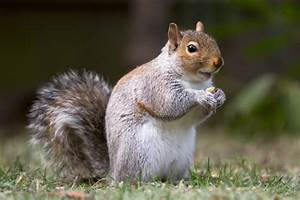

In [36]:
# Load class labels from the saved JSON file
with open(labels_path, "r") as f:
    class_labels = json.load(f)

# Loop through each uploaded image and make a prediction
for fn in uploaded.keys():
    try:
        img_path = fn                                                             # Get file name
        img = image.load_img(img_path, target_size=(224, 224))                    # Load image and resize
        img_array = image.img_to_array(img)                                       # Convert image to numpy array
        img_array = np.expand_dims(img_array, axis=0)                             # Add batch dimension
        img_array = img_array / 255.0                                             # Normalize pixel values

        prediction = model.predict(img_array)                                     # Predict class probabilities
        predicted_class = class_labels[np.argmax(prediction)]                     # Get predicted class label
        confidence = np.max(prediction)                                           # Get highest probability (confidence score)

        print(f"\nPredicted class: {predicted_class} (Confidence: {confidence:.2f})")       # Show result
        display(PILImage.open(img_path))                                                    # Display the uploaded image

    except Exception as e:
        print(f"Error: {e}")          # Handle any errors that occur during prediction


### Inference Result Analysis

The model successfully predicts the class of the uploaded image.

The confidence score represents the maximum predicted probability 
from the softmax output layer.

This demonstrates the full deployment pipeline:

Training → Saving → Loading → Predicting → Interpreting results.